In [24]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting

from sklearn import preprocessing  #用來標準化刻度
from keras.models import Sequential
from keras.layers import Dense,Dropout  
from sklearn.model_selection import train_test_split
from keras.losses import logcosh, categorical_crossentropy
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

####################################################################################  x_lstm_validation
train_cardiac_total=pd.read_csv("mimic_vital_sign_train_24hours.csv")
test_cardiac_total=pd.read_csv("mimic_vital_sign_test_24hours.csv")
train_cardiac_base_total=pd.read_csv("mimic_baseline.csv")

eicu_cardiac_total=pd.read_csv("eicu_total_24hours.csv")

T=24
var=6
random=32
smote_ratio=1
#near_ratio=0.35
EPOCH = 3                    # number of epochs
BATCH = 32                      # batch size

dropout=0.4
LR = 0.001                           # learning rate of the gradient descent
LAMBD = 0.001                       # lambda in L2 regularizaion

#####################################################################################
train_cardiac_base_total=train_cardiac_base_total.drop(['subject_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['hadm_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['stay_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['los'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CA'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['hospDIED'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CMO'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNRDNI'],axis=1)

#train_cardiac_base_total=train_cardiac_base_total.drop(['DNI'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['FullCode'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['indextime'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs9'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs10'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardRv2'],axis=1)

###############CXR##############
#train_cardiac_base_total=train_cardiac_base_total.drop(['Atelectasis'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Cardiomegaly'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Consolidation'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Edema'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Enlarged Cardiomediastinum'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Fracture'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Lesion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Opacity'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['No Finding'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Effusion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Other'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumonia'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumothorax'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Support Devices'],axis=1)
###############CXR##############

#train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity","BMI"])
train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity"])


####################################################################
df_train_base=train_cardiac_base_total[:22029]
y_train=df_train_base[['eventV3']].values   #取train_labels
y_train_base=df_train_base[['eventV3']].values   #取train_labels
df_train_base=df_train_base.drop(['eventV3'],axis=1)
train_features=df_train_base.values

df_test_base=train_cardiac_base_total[22029:]
y_test=df_test_base[['eventV3']].values   #取test_labels
df_test_base=df_test_base.drop(['eventV3'],axis=1)
test_features=df_test_base.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_train_base=minmax_scale.fit_transform(train_features)
x_test_base=minmax_scale.fit_transform(test_features)

#x_train_base=train_features
#x_test_base=test_features

sm = SMOTE(random_state=random, sampling_strategy=smote_ratio)
#nr = NearMiss(sampling_strategy=near_ratio) 

x_train_base, y_train_base = sm.fit_resample(x_train_base, y_train_base.ravel())
#x_train_base, y_train_base = nr.fit_sample(x_train_base, y_train_base.ravel())

train_cardiac_total=train_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']]    
train_cardiac_total=np.array(train_cardiac_total).reshape(22029,T*var) #轉二維  array
train_cardiac_total= pd.DataFrame(train_cardiac_total)

x_test_lstm=test_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 
#x_test_lstm=minmax_scale.fit_transform(x_test_lstm)  #規一化
x_test_lstm=np.array(x_test_lstm).reshape(5507,T,var) 

x_train_lstm, y_train = sm.fit_resample(train_cardiac_total, y_train.ravel())

#x_train_lstm=minmax_scale.fit_transform(x_train_lstm)  #規一化

x_train_lstm=np.array(x_train_lstm).reshape(x_train_lstm.shape[0],T,var) #轉三維  total 

print('timeline:',train_cardiac_total.shape)
print('baseline:',df_train_base.shape)

print('timeline:',x_train_lstm.shape)
print('baseline:',x_train_base.shape)
print('label:',y_train.shape)

print('timeline:',x_test_lstm.shape)
print('baseline:',x_test_base.shape)
print('label:',y_test.shape)

#print(df_train_base.columns)


timeline: (22029, 144)
baseline: (22029, 70)
timeline: (43298, 24, 6)
baseline: (43298, 70)
label: (43298,)
timeline: (5507, 24, 6)
baseline: (5507, 70)
label: (5507, 1)


In [25]:
x_event_0=x_train_lstm[:21649]   #切出正常組 事件組   #loo1
y_event_0=y_train[:21649]

x_event_1=x_train_lstm[21649:]
y_event_1=y_train[21649:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[part_0:], x_event_1[part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1]))

y_train_lstm_new=np.concatenate((y_event_0[part_0:], y_event_1[part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_1 = Sequential()

model_1.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())

model_1.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_1.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_1.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_1.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_1.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_1.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred1= model_1.predict(x_test_lstm)
predict_train_lstm1=model_1.predict(x_train_lstm)

test_acc_1=test_acc
test_precision_1=test_precision


(34640, 24, 6)
(8658, 24, 6)
(34640,)
(8658,)
layers=[8, 8, 8, 1], train_examples=34640, test_examples=5507
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 24, 8)             480       
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 8)             32        
_________________________________________________________________
lstm_11 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 36s - loss: 0.5748 - accuracy: 0.7146 - f1_m: 0.6593 - precision_m: 0.8152 - val_loss: 0.5225 - val_accuracy: 0.7467 - val_f1_m: 0.3661 - val_precision_m: 0.5018
Epoch 3/3
 - 38s - loss: 0.5546 - accuracy: 0.7289 - f1_m: 0.6814 - precision_m: 0.8234 - val_loss: 0.5040 - val_accuracy: 0.7693 - val_f1_m: 0.4083 - val_precision_m: 0.5016
-----------------------------------------------------------------
Training was completed in 120.90 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 76.761%
test accuracy = 83.4393%
test error = 912 out of 5507 examples


In [26]:
predict_test_1=[]
for i in range(y_pred1.shape[0]): 
    if y_pred1[i]>0.5:
        predict_test_1.append(1)
    else:
        predict_test_1.append(0)
predict_test_1 = np.array(predict_test_1)
print(predict_test_1)

[0 0 0 ... 1 0 0]


In [27]:
y_test_1D=np.array(y_test).reshape(5507)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_1,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_1)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4537  875]
 [  37   58]]
specificity: 0.8383222468588323
sensitivity: 0.6105263157894737
ppv: 0.06216505894962487
npv: 0.9919108001749016


In [28]:
x_event_0=x_train_lstm[:21649]   #切出正常組 事件組   #loo2
y_event_0=y_train[:21649]

x_event_1=x_train_lstm[21649:]
y_event_1=y_train[21649:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1],x_event_0[2*part_0:],x_event_1[2*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[part_0:2*part_0], x_event_1[part_1:2*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1],y_event_0[2*part_0:], y_event_1[2*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[part_0:2*part_0], y_event_1[part_1:2*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_2 = Sequential()

model_2.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_2.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_2.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_2.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_2.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_2.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred2= model_2.predict(x_test_lstm)
predict_train_lstm2=model_2.predict(x_train_lstm)

test_acc_2=test_acc
test_precision_2=test_precision


(34640, 24, 6)
(8658, 24, 6)
(34640,)
(8658,)
layers=[8, 8, 8, 1], train_examples=34640, test_examples=5507
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 24, 8)             480       
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_14 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 38s - loss: 0.5551 - accuracy: 0.7389 - f1_m: 0.7214 - precision_m: 0.7689 - val_loss: 0.5624 - val_accuracy: 0.6891 - val_f1_m: 0.4830 - val_precision_m: 0.5014
Epoch 3/3
 - 37s - loss: 0.5309 - accuracy: 0.7557 - f1_m: 0.7432 - precision_m: 0.7790 - val_loss: 0.5318 - val_accuracy: 0.7109 - val_f1_m: 0.4702 - val_precision_m: 0.5017
-----------------------------------------------------------------
Training was completed in 122.93 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 71.0364%
test accuracy = 53.4774%
test error = 2562 out of 5507 examples


In [29]:
predict_test_2=[]
for i in range(y_pred2.shape[0]): 
    if y_pred2[i]>0.5:
        predict_test_2.append(1)
    else:
        predict_test_2.append(0)
predict_test_2 = np.array(predict_test_2)
print(predict_test_2)

[0 1 0 ... 1 0 0]


In [30]:
y_test_1D=np.array(y_test).reshape(5507)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_2,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_2)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[2874 2538]
 [  24   71]]
specificity: 0.5310421286031042
sensitivity: 0.7473684210526316
ppv: 0.027213491759294748
npv: 0.9917184265010351


In [31]:
x_event_0=x_train_lstm[:21649]   #切出正常組 事件組   #loo3
y_event_0=y_train[:21649]

x_event_1=x_train_lstm[21649:]
y_event_1=y_train[21649:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:2*part_0], x_event_1[:2*part_1],x_event_0[3*part_0:],x_event_1[3*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[2*part_0:3*part_0], x_event_1[2*part_1:3*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:2*part_0], y_event_1[:2*part_1],y_event_0[3*part_0:], y_event_1[3*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[2*part_0:3*part_0], y_event_1[2*part_1:3*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_3 = Sequential()

model_3.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_3.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_3.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_3.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_3.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_3.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


y_pred3= model_3.predict(x_test_lstm)
predict_train_lstm3=model_3.predict(x_train_lstm)

test_acc_3=test_acc
test_precision_3=test_precision

(34640, 24, 6)
(8658, 24, 6)
(34640,)
(8658,)
layers=[8, 8, 8, 1], train_examples=34640, test_examples=5507
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 24, 8)             480       
_________________________________________________________________
dropout_15 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_17 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 39s - loss: 0.5764 - accuracy: 0.7219 - f1_m: 0.6919 - precision_m: 0.7746 - val_loss: 0.5268 - val_accuracy: 0.7434 - val_f1_m: 0.3752 - val_precision_m: 0.5016
Epoch 3/3
 - 38s - loss: 0.5602 - accuracy: 0.7283 - f1_m: 0.6984 - precision_m: 0.7842 - val_loss: 0.5135 - val_accuracy: 0.7569 - val_f1_m: 0.4382 - val_precision_m: 0.5017
-----------------------------------------------------------------
Training was completed in 127.24 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 76.0191%
test accuracy = 73.2704%
test error = 1472 out of 5507 examples


In [32]:
predict_test_3=[]
for i in range(y_pred3.shape[0]): 
    if y_pred3[i]>0.5:
        predict_test_3.append(1)
    else:
        predict_test_3.append(0)
predict_test_3 = np.array(predict_test_3)
print(predict_test_3)

[0 0 1 ... 1 0 1]


In [33]:
y_test_1D=np.array(y_test).reshape(5507)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_3,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_3)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[3972 1440]
 [  32   63]]
specificity: 0.7339246119733924
sensitivity: 0.6631578947368421
ppv: 0.041916167664670656
npv: 0.9920079920079921


In [34]:
x_event_0=x_train_lstm[:21649]   #切出正常組 事件組   #loo4
y_event_0=y_train[:21649]

x_event_1=x_train_lstm[21649:]
y_event_1=y_train[21649:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:3*part_0], x_event_1[:3*part_1],x_event_0[4*part_0:],x_event_1[4*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[3*part_0:4*part_0], x_event_1[3*part_1:4*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:3*part_0], y_event_1[:3*part_1],y_event_0[4*part_0:], y_event_1[4*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[3*part_0:4*part_0], y_event_1[3*part_1:4*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_4 = Sequential()

model_4.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_4.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_4.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_4.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_4.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_4.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred4= model_4.predict(x_test_lstm)
predict_train_lstm4=model_4.predict(x_train_lstm)

test_acc_4=test_acc
test_precision_4=test_precision


(34640, 24, 6)
(8658, 24, 6)
(34640,)
(8658,)
layers=[8, 8, 8, 1], train_examples=34640, test_examples=5507
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 24, 8)             480       
_________________________________________________________________
dropout_18 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_20 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 36s - loss: 0.5703 - accuracy: 0.7269 - f1_m: 0.7151 - precision_m: 0.7454 - val_loss: 0.5446 - val_accuracy: 0.7223 - val_f1_m: 0.4635 - val_precision_m: 0.5009
Epoch 3/3
 - 35s - loss: 0.5454 - accuracy: 0.7414 - f1_m: 0.7292 - precision_m: 0.7618 - val_loss: 0.4943 - val_accuracy: 0.7700 - val_f1_m: 0.4527 - val_precision_m: 0.5009
-----------------------------------------------------------------
Training was completed in 123.13 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 77.015%
test accuracy = 71.1821%
test error = 1587 out of 5507 examples


In [35]:
predict_test_4=[]
for i in range(y_pred4.shape[0]): 
    if y_pred4[i]>0.5:
        predict_test_4.append(1)
    else:
        predict_test_4.append(0)
predict_test_4 = np.array(predict_test_4)
print(predict_test_4)

[0 0 0 ... 1 0 1]


In [36]:
y_test_1D=np.array(y_test).reshape(5507)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_4,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_4)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[3855 1557]
 [  30   65]]
specificity: 0.7123059866962306
sensitivity: 0.6842105263157895
ppv: 0.040073982737361284
npv: 0.9922779922779923


In [37]:
x_event_0=x_train_lstm[:21649]   #切出正常組 事件組   #loo5
y_event_0=y_train[:21649]

x_event_1=x_train_lstm[21649:]
y_event_1=y_train[21649:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:4*part_0], x_event_1[:4*part_1]))
x_valid_lstm_new=np.concatenate((x_event_0[4*part_0:], x_event_1[4*part_1:]))

y_train_lstm_new=np.concatenate((y_event_0[:4*part_0], y_event_1[:4*part_1]))
y_valid_lstm_new=np.concatenate((y_event_0[4*part_0:], y_event_1[4*part_1:]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_5 = Sequential()

model_5.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_5.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_5.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_5.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_5.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_5.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred5= model_5.predict(x_test_lstm)
predict_train_lstm5=model_5.predict(x_train_lstm)

test_acc_5=test_acc
test_precision_5=test_precision

(34632, 24, 6)
(8666, 24, 6)
(34632,)
(8666,)
layers=[8, 8, 8, 1], train_examples=34632, test_examples=5507
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 24, 8)             480       
_________________________________________________________________
dropout_21 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_23 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_22 (Dropout)         (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 33s - loss: 0.5674 - accuracy: 0.7314 - f1_m: 0.7035 - precision_m: 0.7808 - val_loss: 0.5765 - val_accuracy: 0.6736 - val_f1_m: 0.4745 - val_precision_m: 0.5010
Epoch 3/3
 - 33s - loss: 0.5537 - accuracy: 0.7421 - f1_m: 0.7170 - precision_m: 0.7897 - val_loss: 0.5408 - val_accuracy: 0.7456 - val_f1_m: 0.4510 - val_precision_m: 0.5014
-----------------------------------------------------------------
Training was completed in 112.62 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 73.8594%
test accuracy = 65.4985%
test error = 1900 out of 5507 examples


In [38]:
predict_test_5=[]
for i in range(y_pred5.shape[0]): 
    if y_pred5[i]>0.5:
        predict_test_5.append(1)
    else:
        predict_test_5.append(0)
predict_test_5 = np.array(predict_test_5)
print(predict_test_5)

[0 0 0 ... 1 0 1]


In [39]:
y_test_1D=np.array(y_test).reshape(5507)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_5,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_5)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[3536 1876]
 [  24   71]]
specificity: 0.6533628972653363
sensitivity: 0.7473684210526316
ppv: 0.036466358500256806
npv: 0.9932584269662922


In [40]:
y_pred_temp=np.append(y_pred1,y_pred2)
y_pred_temp=np.append(y_pred_temp,y_pred3)
y_pred_temp=np.append(y_pred_temp,y_pred4)
y_pred_temp=np.append(y_pred_temp,y_pred5)

predict_train_temp=np.append(predict_train_lstm1,predict_train_lstm2)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm3)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm4)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm5)

y_pred=np.array(y_pred_temp).reshape(x_test_lstm.shape[0],5, order='F') #轉維
predict_train_lstm=np.array(predict_train_temp).reshape(x_train_lstm.shape[0],5, order='F') #轉維

y_pred= np.mean(y_pred, axis=1)
predict_train_lstm= np.mean(predict_train_lstm, axis=1)
 
test_acc=(test_acc_1+test_acc_2+test_acc_3+test_acc_4+test_acc_5)/5
test_precision=(test_precision_1+test_precision_2+test_precision_3+test_precision_4+test_precision_5)/5

In [41]:
predict_test=[]
for i in range(y_pred.shape[0]): 
    if y_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)
print(predict_test)

[0 0 0 ... 1 0 0]


In [42]:
y_test_1D=np.array(y_test).reshape(5507)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


y_pred=np.array(y_pred).reshape(5507)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if y_pred[i]>0.5:
            total_predict=total_predict+y_pred[i]
            flag=flag+1
            

Confusion Matrix : 
 [[4114 1298]
 [  30   65]]
specificity: 0.7601626016260162
sensitivity: 0.6842105263157895
ppv: 0.04768892149669846
npv: 0.7601626016260162


<Figure size 432x288 with 0 Axes>

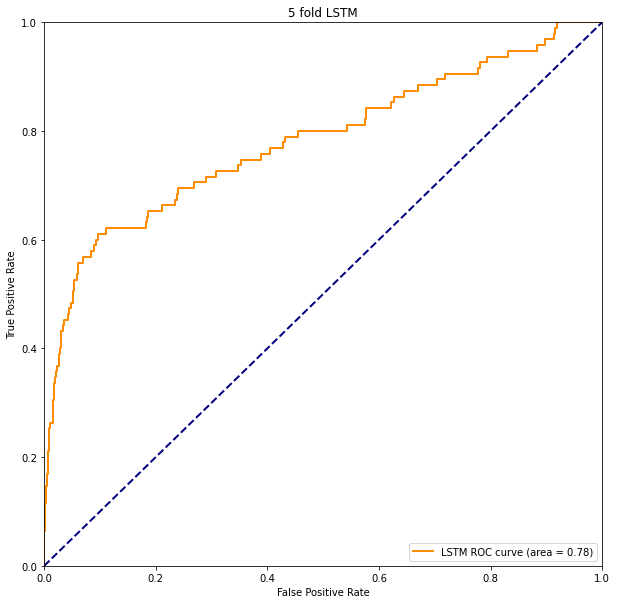

In [43]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5 fold LSTM')
plt.legend(loc="lower right")

plt.show()

In [44]:
print('Accuracy : %0.2f' %test_acc)  #Accuracy
print('precision : %0.2f' %test_precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score


Accuracy : 0.69
precision : 0.02
AUC : 0.78
Sensitivity : 0.68
Specificity :0.76
64.08663954003629


In [45]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import model_selection

forest = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15],
'max_depth': [5]
 }

forest = model_selection.GridSearchCV(forest, rf_params, cv=5)
forest_fit = forest.fit(x_train_base, y_train)

prob_predict_y_validation = forest.predict_proba(x_test_base)#给出带有概率值的结果，每个点所有label的概率和为1
prob_predict_y_validation1 = forest.predict_proba(x_train_base)#给出带有概率值的结果，每个点所有label的概率和为1

y_score = prob_predict_y_validation[:, 1]
# 預測
predict_train_rf = prob_predict_y_validation1[:, 1]

test_y_predicted = forest.predict(x_test_base)

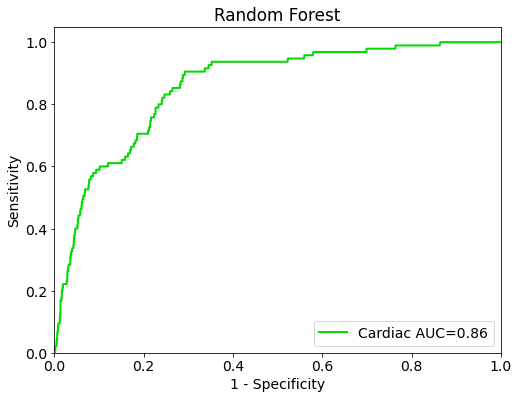

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
#plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('Random Forest')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [47]:
predict_test=[]
for i in range(y_score.shape[0]): 
    if y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(5507)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

Confusion Matrix : 
 [[4767  645]
 [  38   57]]
AUC : 0.86
Sensitivity : 0.60
Specificity :0.88


In [48]:
print(predict_train_rf)
print(predict_train_lstm)

stacking=np.append(predict_train_rf, predict_train_lstm)
x_train_stacking=np.array(stacking).reshape(x_train_lstm.shape[0],2, order='F') #轉維

from sklearn import  svm, preprocessing, metrics 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler

svm = svm.SVC(kernel='linear',probability=True)
svm.fit(x_train_stacking,y_train)

print(x_train_stacking.shape)
print(y_train.shape)

print(y_pred.shape)#lstm test 機率 
print(y_score.shape)#Rf test 機率

stacking_test=np.append(y_pred, y_score)
x_test_stacking=np.array(stacking_test).reshape(5507,2, order='F') #轉維


[0.14416019 0.13970104 0.38055768 ... 0.74085914 0.72277171 0.74080735]
[0.32652014 0.30914322 0.43692437 ... 0.92630327 0.72006786 0.5603668 ]
(43298, 2)
(43298,)
(5507,)
(5507,)


In [49]:
predict=svm.predict(x_test_stacking)
predict_pro=svm.predict_proba(x_test_stacking)

accuracy = metrics.accuracy_score(y_test, predict)
precision  = metrics.precision_score(y_test, predict)

print(accuracy)
print(precision)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro=predict_pro[:,1:2]

#################92個test ca 輸出#####################
#test=pd.DataFrame(predict[4689:])
#test.to_csv('24hour_ca.csv', index=False)
#######################################

0.9010350463047031
0.11604095563139932


In [50]:
pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)
flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if predict_pro[i]>0.5:
            total_predict=total_predict+predict_pro[i]
            flag=flag+1
#print(flag)  #score

print(y_test_1D)

Confusion Matrix : 
 [[4894  518]
 [  27   68]]
specificity: 0.9042867701404287
sensitivity: 0.7157894736842105
ppv: 0.11604095563139932
npv: 0.9042867701404287
[0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

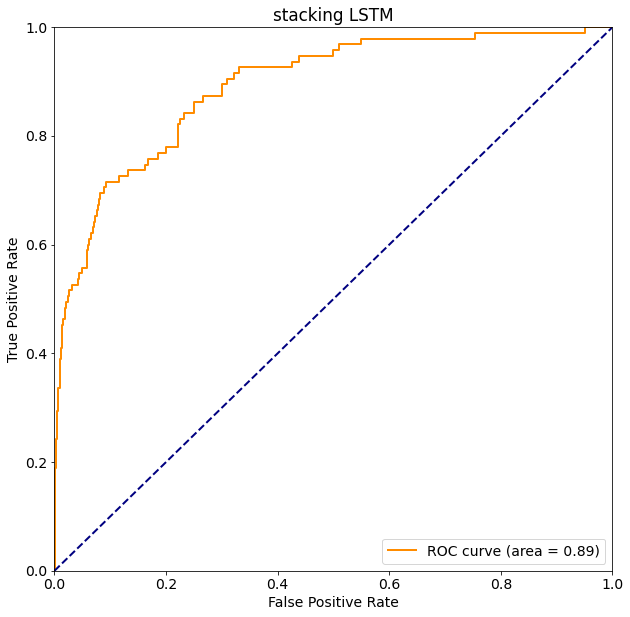

In [51]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, predict_pro) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('stacking LSTM')
plt.legend(loc="lower right")

plt.show()

In [52]:
print('Accuracy : %0.2f' %accuracy)  #Accuracy
print('precision : %0.2f' %precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

Accuracy : 0.90
precision : 0.12
AUC : 0.89
Sensitivity : 0.72
Specificity :0.90
[76.75894711]


In [53]:
df_eicu=pd.read_csv("cascontrol_f2.csv")  #baseline 

y_validation=df_eicu['user']

x_lstm_validation=eicu_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 

#x_lstm_validation=minmax_scale.fit_transform(x_lstm_validation)  #規一化
x_lstm_validation=np.array(x_lstm_validation).reshape(10665,T,var) #轉三維  total 

print(x_lstm_validation.shape)
print(y_validation.shape)

(10665, 24, 6)
(10665,)


-----------------------------------------------------------------
test accuracy = 82.1753%
test error = 1901 out of 10665 examples


<Figure size 432x288 with 0 Axes>

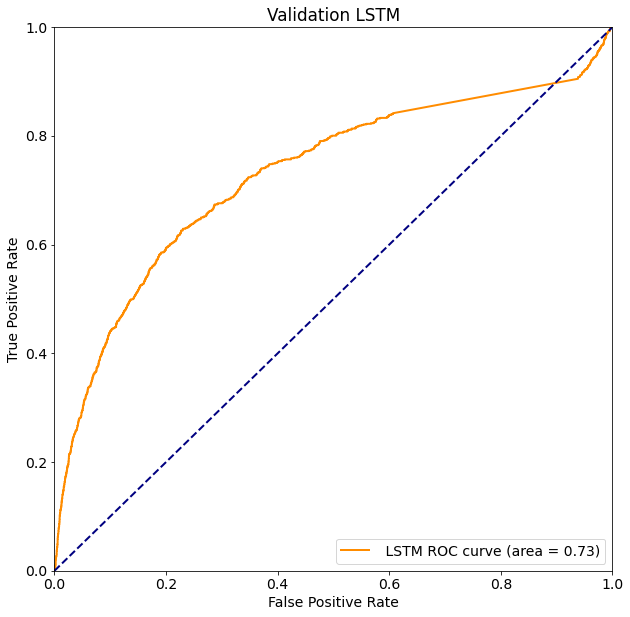

In [54]:
test_loss_1 ,test_acc_1, test_f1_score_1, test_precision_1 = model_1.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_1 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_1) * 10665)} out of {10665} examples')

validation_pred1= model_1.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred1) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

-----------------------------------------------------------------
test accuracy = 44.6976%
test error = 5898 out of 10665 examples


<Figure size 432x288 with 0 Axes>

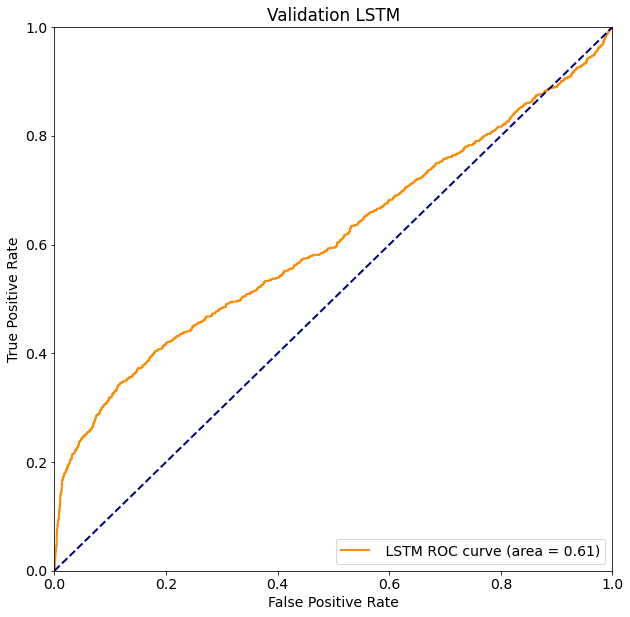

In [55]:
test_loss_2 ,test_acc_2, test_f1_score_2, test_precision_2 = model_2.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_2 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_2) * 10665)} out of {10665} examples')

validation_pred2= model_2.predict(x_lstm_validation)


# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred2) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 52.0113%
test error = 5118 out of 10665 examples


<Figure size 432x288 with 0 Axes>

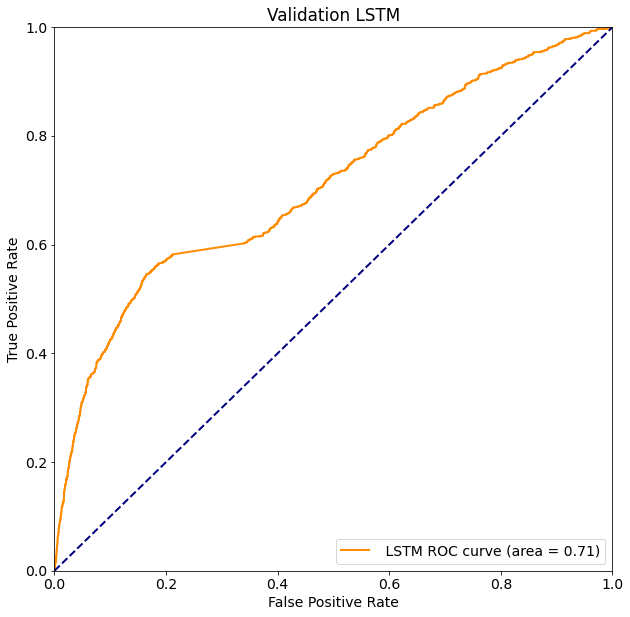

In [56]:
test_loss_3 ,test_acc_3, test_f1_score_3, test_precision_3 = model_3.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_3 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_3) * 10665)} out of {10665} examples')

validation_pred3= model_3.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred3) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 45.7665%
test error = 5784 out of 10665 examples


<Figure size 432x288 with 0 Axes>

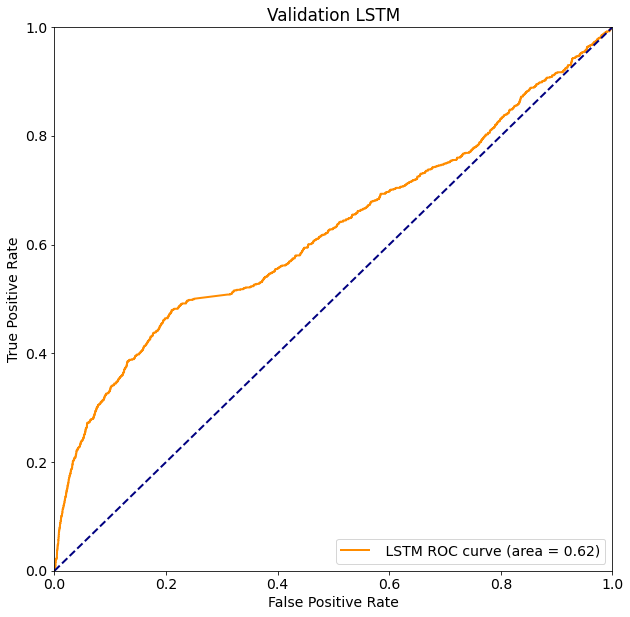

In [57]:
test_loss_4 ,test_acc_4, test_f1_score_4, test_precision_4 = model_4.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_4 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_4) * 10665)} out of {10665} examples')

validation_pred4= model_4.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred4) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 43.6568%
test error = 6009 out of 10665 examples


<Figure size 432x288 with 0 Axes>

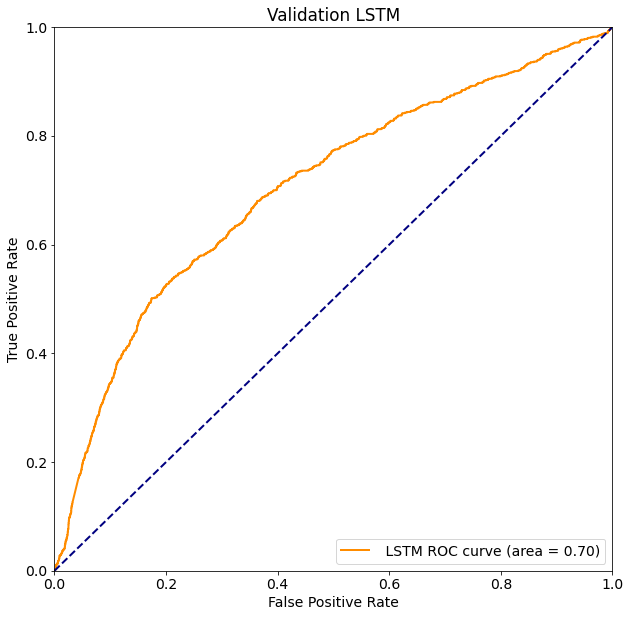

In [58]:
test_loss_5 ,test_acc_5, test_f1_score_5, test_precision_5 = model_5.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_5 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_5) * 10665)} out of {10665} examples')

validation_pred5= model_5.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred5) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [59]:
pred_temp=np.append(validation_pred1,validation_pred2)
pred_temp=np.append(pred_temp,validation_pred3)
pred_temp=np.append(pred_temp,validation_pred4)
pred_temp=np.append(pred_temp,validation_pred5)

validation_pred=np.array(pred_temp).reshape(10665,5, order='F') #轉維

validation_pred= np.mean(validation_pred, axis=1)
 
eicu_acc=(test_acc_1+test_acc_2+test_acc_3+test_acc_4+test_acc_5)/5
eicu_precision=(test_precision_1+test_precision_2+test_precision_3+test_precision_4+test_precision_5)/5

<Figure size 432x288 with 0 Axes>

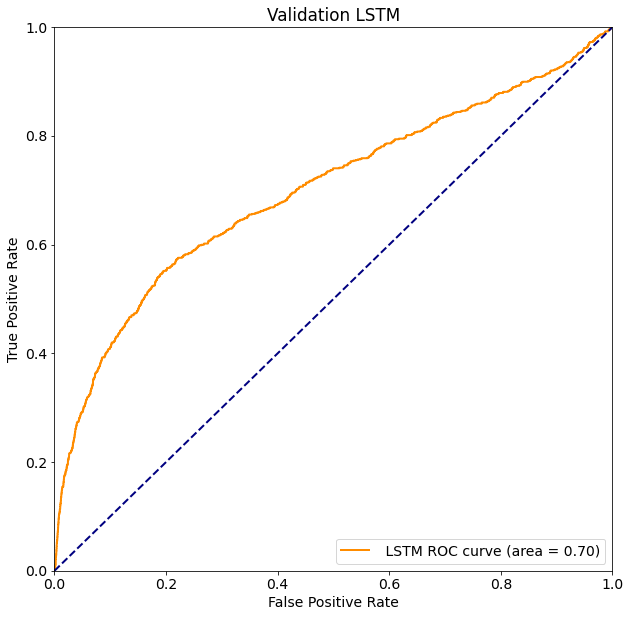

In [60]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [61]:
y_validation_1D=np.array(y_validation).reshape(10665)

predict_test=[]
for i in range(validation_pred.shape[0]): 
    if validation_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

pd.crosstab(y_validation_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_validation_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


Confusion Matrix : 
 [[5201 4547]
 [ 255  662]]


In [62]:
df_eicu=pd.read_csv("cascontrol_f2.csv")  #baseline 

df_eicu=df_eicu.drop(['patientunitstayid'],axis=1)
df_eicu=df_eicu.drop(['patienthealthsystemstayid'],axis=1)
df_eicu=df_eicu.drop(['uniquepid'],axis=1)
df_eicu=df_eicu.drop(['CA'],axis=1)
df_eicu=df_eicu.drop(['hDied'],axis=1)

df_eicu=df_eicu.drop(['BMI'],axis=1)
df_eicu=df_eicu.drop(['ccscore'],axis=1)

#df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity","BMI"])
df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity"])

y_validation=df_eicu['user']
df_eicu=df_eicu.drop(['user'],axis=1)
x_validation=df_eicu.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

#x_validation=minmax_scale.fit_transform(x_validation)

predict_validation = forest.predict_proba(x_validation)#给出带有概率值的结果，每个点所有label的概率和为1
y_score_validation = predict_validation[:, 1] #RF

predict_test=[]
for i in range(y_score_validation.shape[0]): 
    if y_score_validation[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_validation).reshape(10665)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR



Confusion Matrix : 
 [[9424  324]
 [ 728  189]]


In [63]:
stacking_validation_test=np.append(validation_pred, y_score_validation)
x_test_stacking=np.array(stacking_validation_test).reshape(10665,2, order='F') #轉維

predict=svm.predict(x_test_stacking)
predict_pro=svm.predict_proba(x_test_stacking)

accuracy = metrics.accuracy_score(y_validation, predict)
precision  = metrics.precision_score(y_validation, predict)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro=predict_pro[:,1:2]

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if predict_pro[i]>0.5:
            total_predict=total_predict+predict_pro[i]
            flag=flag+1
#print(flag)  #score



Confusion Matrix : 
 [[8620 1128]
 [ 460  457]]
specificity: 0.884283955683217
sensitivity: 0.4983642311886587
ppv: 0.2883280757097792
npv: 0.9493392070484582


<Figure size 432x288 with 0 Axes>

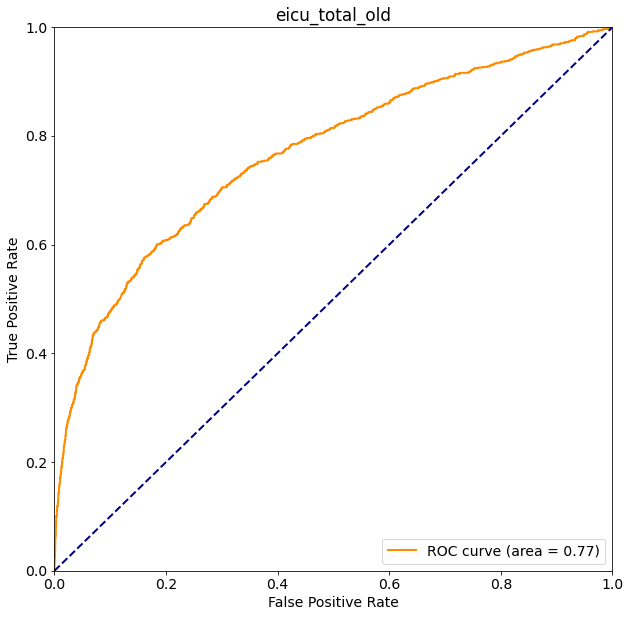

In [64]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, predict_pro) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('eicu_total_old')
plt.legend(loc="lower right")

plt.show()

predict_pro =pd.DataFrame(predict_pro)
predict_pro.to_csv('predict.csv', index=False)

In [65]:
test_acc=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])
print('Accuracy : %0.2f' %test_acc)  #Accuracy
print('precision : %0.2f' %test_precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
print('ppv : %0.2f' % ppv )
print('npv :%0.2f' % npv)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
#print(total_predict/flag*100)  #score

Accuracy : 0.85
precision : 0.02
AUC : 0.77
Sensitivity : 0.50
Specificity :0.88
ppv : 0.29
npv :0.95


In [66]:
df_eicu_new=pd.read_csv("baseline_eicu_version2.csv")  #baseline 
eicu_cardiac_total_new=pd.read_csv("eicu_version2_24hours.csv") #vital sign

y_validation=df_eicu_new['user']

x_lstm_validation_new=eicu_cardiac_total_new[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 

#x_lstm_validation=minmax_scale.fit_transform(x_lstm_validation)  #規一化
x_lstm_validation_new=np.array(x_lstm_validation_new).reshape(10049,T,var) #轉三維  total 

print(x_lstm_validation_new.shape)
print(y_validation.shape)

(10049, 24, 6)
(10049,)


-----------------------------------------------------------------
test accuracy = 84.8741%
test error = 1520 out of 10049 examples


<Figure size 432x288 with 0 Axes>

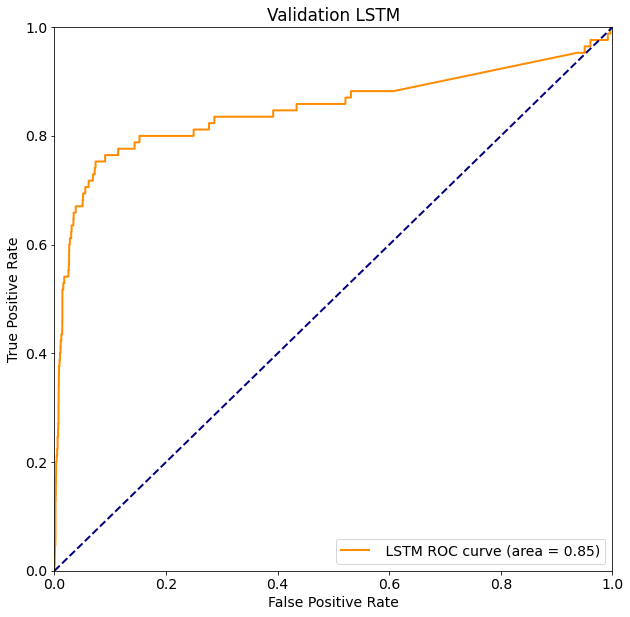

In [67]:
test_loss_1 ,test_acc_1, test_f1_score_1, test_precision_1 = model_1.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_1 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_1) * 10049)} out of {10049} examples')

validation_pred1= model_1.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred1) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

-----------------------------------------------------------------
test accuracy = 42.9794%
test error = 5730 out of 10049 examples


<Figure size 432x288 with 0 Axes>

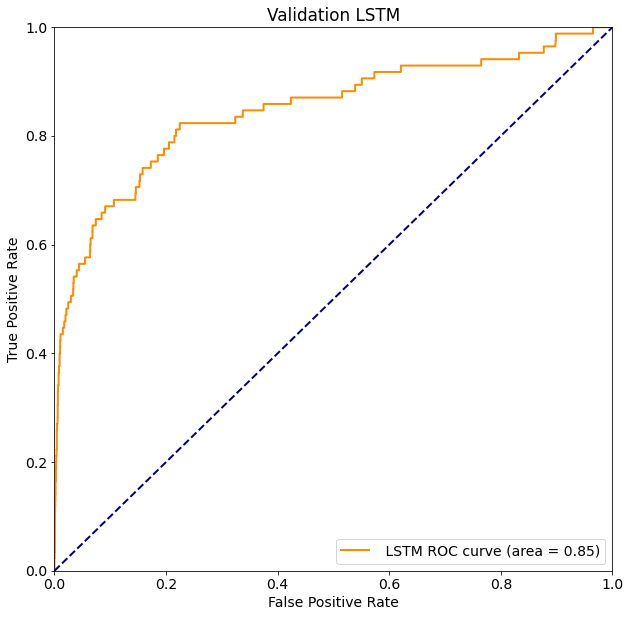

In [68]:
test_loss_2 ,test_acc_2, test_f1_score_2, test_precision_2 = model_2.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_2 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_2) * 10049)} out of {10049} examples')

validation_pred2= model_2.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred2) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

-----------------------------------------------------------------
test accuracy = 50.3135%
test error = 4993 out of 10049 examples


<Figure size 432x288 with 0 Axes>

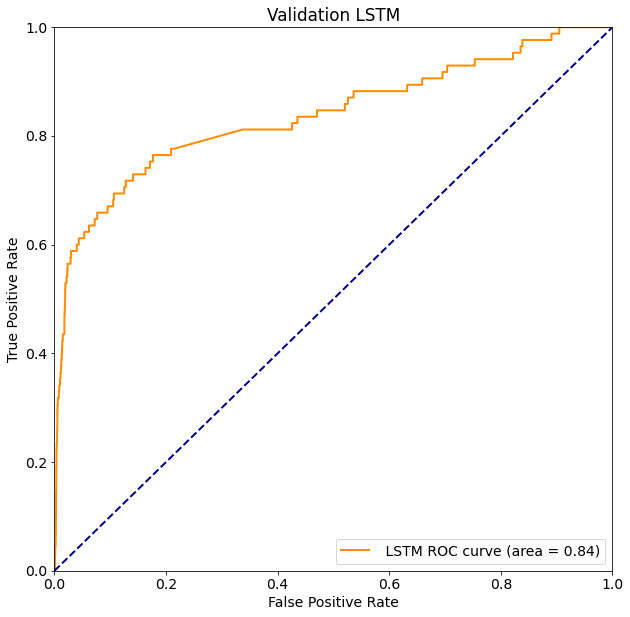

In [69]:
test_loss_3 ,test_acc_3, test_f1_score_3, test_precision_3 = model_3.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_3 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_3) * 10049)} out of {10049} examples')

validation_pred3= model_3.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred3) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 44.2034%
test error = 5607 out of 10049 examples


<Figure size 432x288 with 0 Axes>

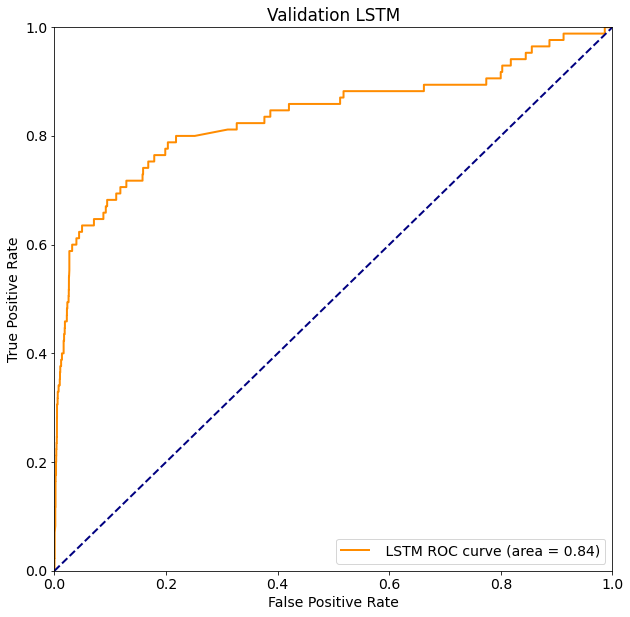

In [70]:
test_loss_4 ,test_acc_4, test_f1_score_4, test_precision_4 = model_4.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_4 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_4) * 10049)} out of {10049} examples')

validation_pred4= model_4.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred4) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 40.2727%
test error = 6002 out of 10049 examples


<Figure size 432x288 with 0 Axes>

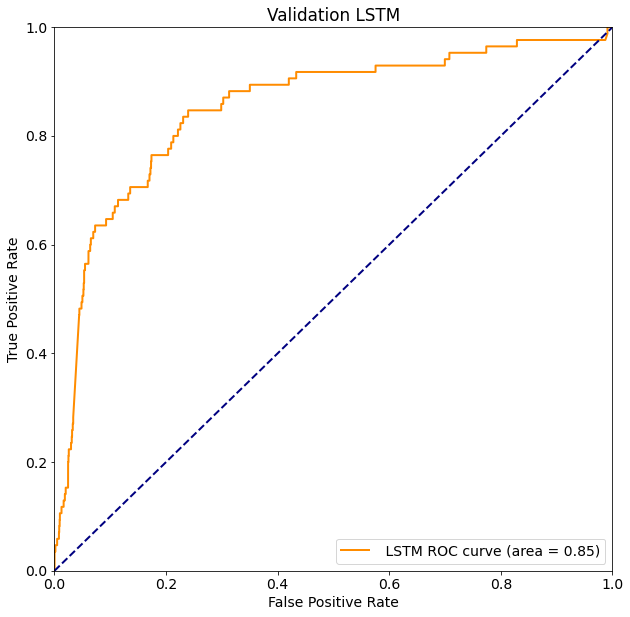

In [71]:
test_loss_5 ,test_acc_5, test_f1_score_5, test_precision_5 = model_5.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_5 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_5) * 10049)} out of {10049} examples')

validation_pred5= model_5.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred5) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [72]:
pred_temp=np.append(validation_pred1,validation_pred2)
pred_temp=np.append(pred_temp,validation_pred3)
pred_temp=np.append(pred_temp,validation_pred4)
pred_temp=np.append(pred_temp,validation_pred5)

validation_pred=np.array(pred_temp).reshape(10049,5, order='F') #轉維

validation_pred= np.mean(validation_pred, axis=1)
 
eicu_acc=(test_acc_1+test_acc_2+test_acc_3+test_acc_4+test_acc_5)/5
eicu_precision=(test_precision_1+test_precision_2+test_precision_3+test_precision_4+test_precision_5)/5

<Figure size 432x288 with 0 Axes>

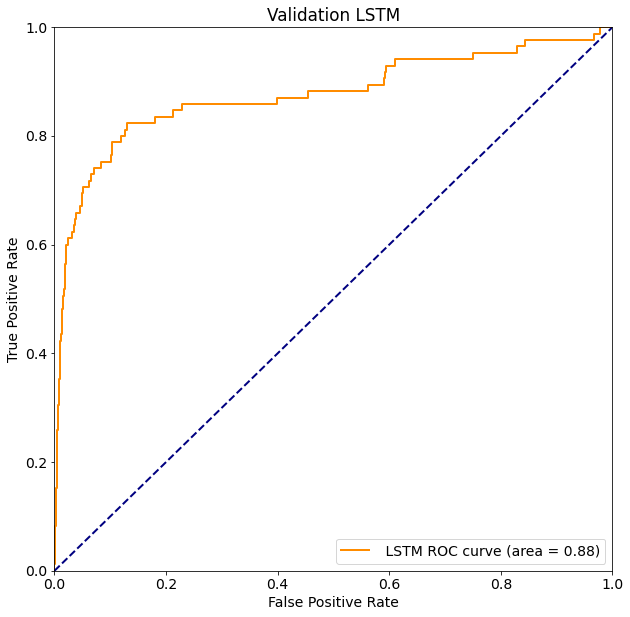

In [73]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [74]:
y_validation_1D=np.array(y_validation).reshape(10049)

predict_test=[]
for i in range(validation_pred.shape[0]): 
    if validation_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

pd.crosstab(y_validation_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_validation_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


Confusion Matrix : 
 [[5302 4662]
 [  10   75]]


In [75]:
df_eicu=pd.read_csv("baseline_eicu_version2.csv")  #baseline 

df_eicu=df_eicu.drop(['patientunitstayid'],axis=1)
df_eicu=df_eicu.drop(['patienthealthsystemstayid'],axis=1)
df_eicu=df_eicu.drop(['uniquepid'],axis=1)
df_eicu=df_eicu.drop(['CA'],axis=1)
df_eicu=df_eicu.drop(['hDied'],axis=1)

df_eicu=df_eicu.drop(['BMI'],axis=1)
df_eicu=df_eicu.drop(['ccscore'],axis=1)

#df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity","BMI"])
df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity"])

y_validation=df_eicu['user']
df_eicu=df_eicu.drop(['user'],axis=1)
x_validation=df_eicu.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

#x_validation=minmax_scale.fit_transform(x_validation)

predict_validation = forest.predict_proba(x_validation)#给出带有概率值的结果，每个点所有label的概率和为1
y_score_validation = predict_validation[:, 1] #RF

predict_test=[]
for i in range(y_score_validation.shape[0]): 
    if y_score_validation[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_validation).reshape(10049)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR



Confusion Matrix : 
 [[9617  347]
 [  69   16]]


In [76]:
stacking_validation_test=np.append(validation_pred, y_score_validation)
x_test_stacking=np.array(stacking_validation_test).reshape(10049,2, order='F') #轉維

predict=svm.predict(x_test_stacking)
predict_pro=svm.predict_proba(x_test_stacking)

accuracy = metrics.accuracy_score(y_validation, predict)
precision  = metrics.precision_score(y_validation, predict)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro=predict_pro[:,1:2]

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if predict_pro[i]>0.5:
            total_predict=total_predict+predict_pro[i]
            flag=flag+1
#print(flag)  #score



Confusion Matrix : 
 [[8790 1174]
 [  15   70]]
specificity: 0.8821758329987957
sensitivity: 0.8235294117647058
ppv: 0.05627009646302251
npv: 0.9982964224872232


<Figure size 432x288 with 0 Axes>

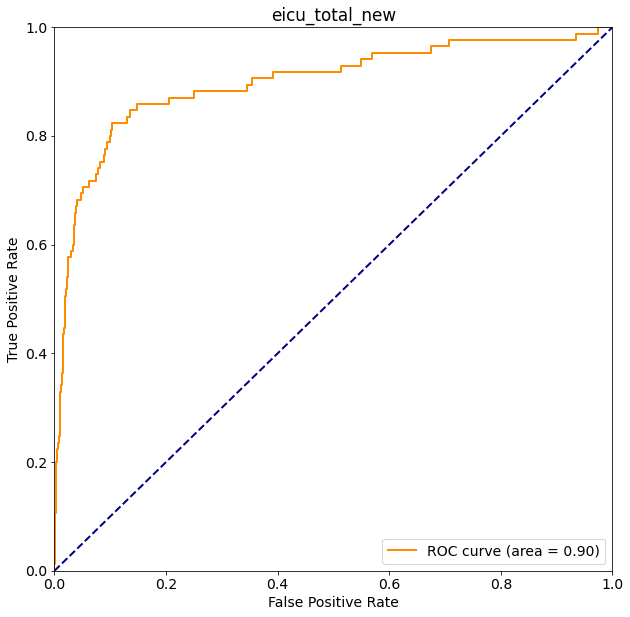

In [77]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, predict_pro) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('eicu_total_new')
plt.legend(loc="lower right")

plt.show()

predict_pro =pd.DataFrame(predict_pro)
predict_pro.to_csv('predict.csv', index=False)

In [78]:
test_acc=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])
print('Accuracy : %0.2f' %test_acc)  #Accuracy
print('precision : %0.2f' %test_precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
print('ppv : %0.2f' % ppv )
print('npv :%0.2f' % npv)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
#print(total_predict/flag*100)  #score

Accuracy : 0.88
precision : 0.02
AUC : 0.90
Sensitivity : 0.82
Specificity :0.88
ppv : 0.06
npv :1.00
